In [ ]:
!pip install scikit-learn pyyaml


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 1: Fresh unzip from Drive intoclean a  working folder

import os, shutil, zipfile
from pathlib import Path

ZIP_PATH  = "/content/drive/MyDrive/updated/updatefdata.zip"  # your zip on Drive
DEST_DIR  = "/content/finaldata"                       # workspace in Colab

# 1) Clean any previous extraction
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR, exist_ok=True)

# 2) Unzip
assert os.path.exists(ZIP_PATH), f"ZIP not found at: {ZIP_PATH}"
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(DEST_DIR)

# 3) Show top-level contents
print("✅ Unzipped to:", DEST_DIR)
print("Top-level contents:", os.listdir(DEST_DIR)[:50])


✅ Unzipped to: /content/finaldata
Top-level contents: ['notes.json', 'classes.txt', 'images', 'labels']


In [ ]:
# === STEP 1: MERGE CLASSES (universal version) ===
import os, glob, shutil, yaml, time
from collections import Counter
from pathlib import Path

DATASET_DIR = Path("/content/finaldata")
LABELS_DIR  = DATASET_DIR / "labels"
CLASSES_TXT = DATASET_DIR / "classes.txt"
DATA_YAML   = DATASET_DIR / "data.yaml"

assert LABELS_DIR.exists(), "labels/ folder not found"

# 1) Load class names
if CLASSES_TXT.exists():
    with open(CLASSES_TXT, "r", encoding="utf-8") as f:
        old_names = [ln.strip() for ln in f if ln.strip()]
else:
    with open(DATA_YAML, "r", encoding="utf-8") as f:
        old_names = yaml.safe_load(f).get("names", [])

print("Old classes:", old_names)

# 2) Define merges
merge_to = {
    "SUMMARY": "SUMMARY",
    "PERSONAL_INFO": "HEADER_INFO",
    "CONTACT": "HEADER_INFO",
    "EXPERIENCE": "EXPERIENCE",
    "PROJECTS/certifications": "EXPERIENCE",
    "EDUCATION": "EDUCATION",
    "LANGUES": "SKILLS",
    "SKILLS": "SKILLS",
    "OTHERS": "OTHERS"
}

for n in old_names:
    merge_to.setdefault(n, n)

new_names = []
for n in [merge_to[n] for n in old_names if merge_to[n] is not None]:
    if n not in new_names:
        new_names.append(n)

name2new = {n:i for i,n in enumerate(new_names)}
name2old = {n:i for i,n in enumerate(old_names)}
oldidx_to_newidx = {i:(None if merge_to[n] is None else name2new[merge_to[n]]) for n,i in name2old.items()}

print("New classes:", new_names)

# 3) Backup labels
stamp = time.strftime("%Y%m%d-%H%M%S")
backup = DATASET_DIR / f"labels_backup_before_merge_{stamp}"
shutil.copytree(LABELS_DIR, backup)
print(f"✅ Backup created: {backup}")

# 4) Rewrite all .txt files recursively
label_files = glob.glob(str(LABELS_DIR / "**" / "*.txt"), recursive=True)
before, after = Counter(), Counter()

for lf in label_files:
    with open(lf, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    new_lines = []
    for ln in lines:
        parts = ln.split()
        if len(parts) < 5:
            continue
        cid = int(float(parts[0]))
        if cid >= len(old_names):  # skip broken id
            continue
        new_cid = oldidx_to_newidx[cid]
        if new_cid is None:
            continue
        before[cid] += 1
        after[new_cid] += 1
        new_lines.append(" ".join([str(new_cid)] + parts[1:5]) + "\n")

    with open(lf, "w", encoding="utf-8") as f:
        f.writelines(new_lines)

print("\n✅ Merge done.")
print("Before:", dict(before))
print("After:", dict(after))

# 5) Update classes.txt & data.yaml
with open(CLASSES_TXT, "w", encoding="utf-8") as f:
    f.write("\n".join(new_names))

if DATA_YAML.exists():
    with open(DATA_YAML, "r", encoding="utf-8") as f:
        y = yaml.safe_load(f)
else:
    y = {}
y["names"] = new_names
y["nc"] = len(new_names)

with open(DATA_YAML, "w", encoding="utf-8") as f:
    yaml.safe_dump(y, f, sort_keys=False)
print("✅ data.yaml & classes.txt updated.")


Old classes: ['CONTACT', 'EDUCATION', 'EXPERIENCE', 'LANGUES', 'OTHERS', 'PERSONAL_INFO', 'PROJECTS/certifications', 'SKILLS', 'SUMMARY']
New classes: ['HEADER_INFO', 'EDUCATION', 'EXPERIENCE', 'SKILLS', 'OTHERS', 'SUMMARY']
✅ Backup created: /content/finaldata/labels_backup_before_merge_20251103-034603

✅ Merge done.
Before: {5: 947, 8: 440, 0: 564, 7: 1044, 3: 518, 4: 565, 1: 781, 2: 1157, 6: 196}
After: {0: 1511, 5: 440, 3: 1562, 4: 565, 1: 781, 2: 1353}
✅ data.yaml & classes.txt updated.


In [ ]:
# === STEP: REMOVE OTHERS CLASS COMPLETELY ===
import os, yaml, glob, shutil
from pathlib import Path

DATASET_DIR = Path("/content/finaldata")
LABELS_DIR  = DATASET_DIR / "labels"
CLASSES_TXT = DATASET_DIR / "classes.txt"
DATA_YAML   = DATASET_DIR / "data.yaml"

# 1) Load current class names
with open(CLASSES_TXT, "r", encoding="utf-8") as f:
    names = [ln.strip() for ln in f if ln.strip()]

print("Old classes:", names)
if "OTHERS" not in names:
    print("✅ No OTHERS class found — nothing to drop.")
else:
    drop_name = "OTHERS"
    drop_id = names.index(drop_name)
    print(f"🚫 Dropping class '{drop_name}' (id={drop_id})")

    # 2) Remove from classes.txt and data.yaml
    new_names = [n for n in names if n != drop_name]
    with open(CLASSES_TXT, "w", encoding="utf-8") as f:
        f.write("\n".join(new_names))
    print("✅ Updated classes.txt")

    if DATA_YAML.exists():
        with open(DATA_YAML, "r", encoding="utf-8") as f:
            y = yaml.safe_load(f)
        y["names"] = new_names
        y["nc"] = len(new_names)
        with open(DATA_YAML, "w", encoding="utf-8") as f:
            yaml.safe_dump(y, f, sort_keys=False)
        print("✅ Updated data.yaml")

    # 3) Rewrite labels (remove OTHERS objects and remap IDs)
    label_files = glob.glob(str(LABELS_DIR / "**" / "*.txt"), recursive=True)
    print(f"Found {len(label_files)} label files.")
    removed_count, kept_count = 0, 0

    for lf in label_files:
        with open(lf, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        new_lines = []
        for ln in lines:
            parts = ln.split()
            if len(parts) < 5:
                continue
            cid = int(float(parts[0]))
            if cid == drop_id:
                removed_count += 1
                continue
            # adjust indices if needed (since IDs > drop_id must shift -1)
            if cid > drop_id:
                cid -= 1
            new_lines.append(" ".join([str(cid)] + parts[1:5]) + "\n")
            kept_count += 1

        with open(lf, "w", encoding="utf-8") as f:
            f.writelines(new_lines)

    print(f"✅ Removed {removed_count} 'OTHERS' boxes. Kept {kept_count}.")
    print(f"✅ Now training with {len(new_names)} classes:", new_names)


Old classes: ['HEADER_INFO', 'EDUCATION', 'EXPERIENCE', 'SKILLS', 'OTHERS', 'SUMMARY']
🚫 Dropping class 'OTHERS' (id=4)
✅ Updated classes.txt
✅ Updated data.yaml
Found 1119 label files.
✅ Removed 565 'OTHERS' boxes. Kept 5647.
✅ Now training with 5 classes: ['HEADER_INFO', 'EDUCATION', 'EXPERIENCE', 'SKILLS', 'SUMMARY']


In [ ]:
# === STEP 2: SPLIT DATASET ===
import os, random, shutil
from pathlib import Path
from tqdm import tqdm

DATASET_DIR = Path("/content/finaldata")
IMAGES_DIR  = DATASET_DIR / "images"
LABELS_DIR  = DATASET_DIR / "labels"

# Check flat layout first
flat_images = list(IMAGES_DIR.glob("*.jpg")) + list(IMAGES_DIR.glob("*.png"))
flat_labels = list(LABELS_DIR.glob("*.txt"))

if flat_images:
    print(f"Found {len(flat_images)} images in flat folder. Splitting now...")

    # Define splits
    random.shuffle(flat_images)
    n = len(flat_images)
    train, val, test = int(0.8*n), int(0.9*n), n
    splits = {
        "train": flat_images[:train],
        "val": flat_images[train:val],
        "test": flat_images[val:]
    }

    for sp, imgs in splits.items():
        img_out = IMAGES_DIR / sp
        lbl_out = LABELS_DIR / sp
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(lbl_out, exist_ok=True)

        for im in tqdm(imgs, desc=f"Copying {sp}"):
            shutil.copy(im, img_out / im.name)
            lbl = LABELS_DIR / (im.stem + ".txt")
            if lbl.exists():
                shutil.copy(lbl, lbl_out / lbl.name)

    print("✅ Split complete.")
else:
    print("Dataset already split. Skipping.")


Found 1117 images in flat folder. Splitting now...


Copying test: 100%|██████████| 112/112 [00:00<00:00, 519.46it/s]

✅ Split complete.


In [ ]:
import yaml
from pathlib import Path

root = Path("/content/finaldata")
data_yaml = {
    "train": str((root / "images/train").resolve()),
    "val": str((root / "images/val").resolve()),
    "test": str((root / "images/test").resolve()),
    "nc": len(open(root / "classes.txt").read().splitlines()),
    "names": open(root / "classes.txt").read().splitlines()
}
with open(root / "data.yaml", "w", encoding="utf-8") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)
print("✅ data.yaml ready for YOLO training.")


✅ data.yaml ready for YOLO training.


In [ ]:
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path

data_yaml = str(Path("/content/YOLO_DATA/data.yaml").resolve())


model = YOLO("yolov8m.pt")

results = model.train(
    data=data_yaml,
    epochs=100,
    imgsz=640,
    batch=16,
    optimizer="auto",
    patience=20,
    device=0,
    workers=2,
    cache=True,
    pretrained=True,
)

print("✅ Training complete. Best weights at:", results.save_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/finaldata/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, 

In [ ]:
from ultralytics import YOLO
from pathlib import Path

root = Path("/content/finaldata")
data_yaml = str((root / "data.yaml").resolve())
weights   = "runs/detect/train/weights/best.pt"  # from your training

model = YOLO(weights)
print("Loaded:", weights)


Loaded: runs/detect/train/weights/best.pt


In [ ]:
# Evaluate strictly on images/test with plots & JSON
metrics = model.val(data=data_yaml, split='test', plots=True, save_json=True)
print("✅ Test evaluation saved to:", metrics.save_dir)


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 67.9±32.6 MB/s, size: 540.6 KB)
val: Scanning /content/finaldata/labels/test... 210 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 210/210 154.1it/s 1.4s
val: New cache created: /content/finaldata/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 0.9it/s 16.0s
                   all        210       1040      0.943      0.942      0.977      0.879
           HEADER_INFO        151        282      0.926      0.933      0.974      0.825
             EDUCATION        138        140      0.937      0.986      0.984      0.919
            EXPERIENCE        189        250       0.94      0.952      0.977      0.922
                SKILLS        157        296      0.955      0.867       0.96    

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


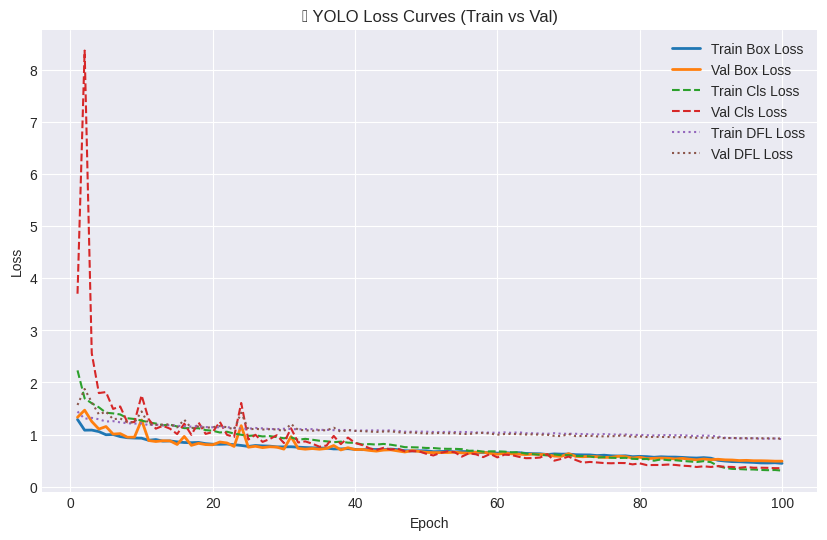

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


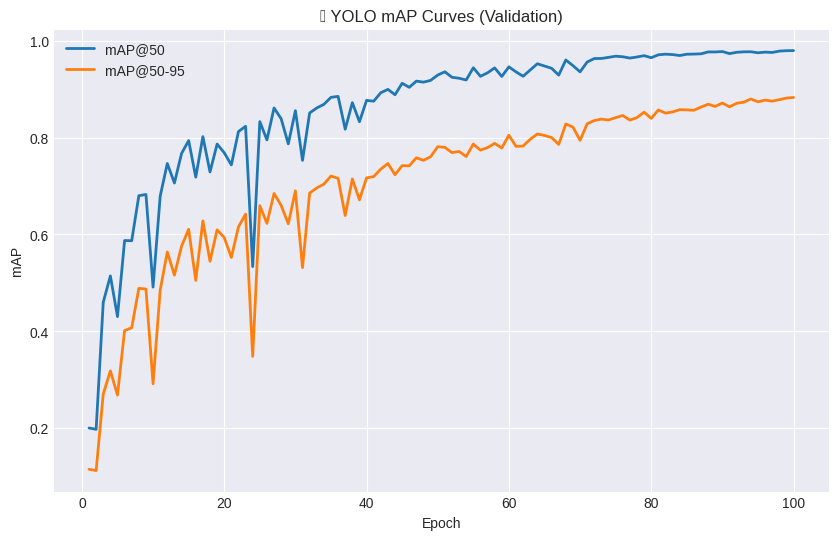

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


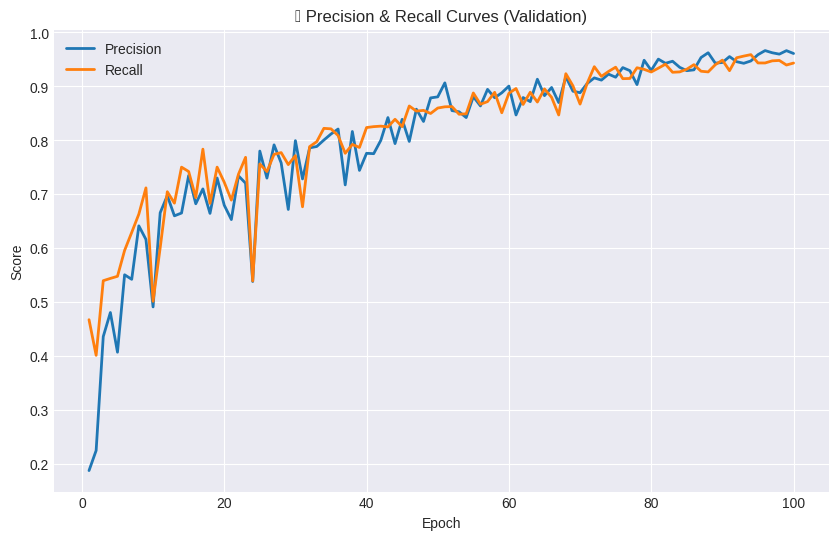

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load YOLO training results ===
csv_path = "/content/runs/detect/train/results.csv"  # change if needed
df = pd.read_csv(csv_path)

# === Plot configuration ===
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)

# === 1. Loss curves ===
plt.figure()
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linewidth=2)
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linewidth=2)
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', linestyle='--')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', linestyle='--')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', linestyle=':')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 YOLO Loss Curves (Train vs Val)")
plt.legend()
plt.show()

# === 2. mAP curves ===
plt.figure()
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', linewidth=2)
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("📈 YOLO mAP Curves (Validation)")
plt.legend()
plt.show()

# === 3. Precision & Recall ===
plt.figure()
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2)
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("📊 Precision & Recall Curves (Validation)")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("/content/runs/detect/train/results.csv")

last = df.iloc[-1]
gap = {
    "Box Loss Δ": last["train/box_loss"] - last["val/box_loss"],
    "Cls Loss Δ": last["train/cls_loss"] - last["val/cls_loss"],
    "DFL Loss Δ": last["train/dfl_loss"] - last["val/dfl_loss"],
    "mAP@50": last["metrics/mAP50(B)"],
    "mAP@50-95": last["metrics/mAP50-95(B)"],
    "Precision": last["metrics/precision(B)"],
    "Recall": last["metrics/recall(B)"]
}

print("📊 Final-epoch summary:\n")
for k, v in gap.items():
    print(f"{k:<15} {v:.4f}")


📊 Final-epoch summary:

Box Loss Δ      -0.0418
Cls Loss Δ      -0.0462
DFL Loss Δ      -0.0117
mAP@50          0.9798
mAP@50-95       0.8829
Precision       0.9610
Recall          0.9433


In [ ]:
import time
from ultralytics import YOLO
import cv2

# Load your trained model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Load a sample image
img_path = "/content/resume_010_page_1.png"  # change path
img = cv2.imread(img_path)

# Warm-up (GPU initialization)
for _ in range(5):
    _ = model.predict(img, verbose=False)

# Measure inference time over N runs
N = 50
start = time.time()
for _ in range(N):
    results = model.predict(img, verbose=False)
end = time.time()

avg_time = (end - start) / N * 1000  # ms
fps = 1000 / avg_time

print(f"⚡ Average Inference Time: {avg_time:.2f} ms per image")
print(f"🎯 Throughput: {fps:.2f} FPS")


⚡ Average Inference Time: 19.41 ms per image
🎯 Throughput: 51.53 FPS
